# Analysis of the results

This notebook investigates the results of all the model runs in the directory `results/runs`.

## Imports and hardcoded variables

In [14]:
import os

import arviz as az
import numpy as np
import pandas as pd
import xarray

from matplotlib import pyplot as plt
from pprint import pprint

RESULTS_DIR = os.path.join("results", "runs")
ARVIZ_STYLE = "arviz-redish"

## Loading InferenceData objects

The results of the analysis are stored as [`InferenceData`](https://arviz-devs.github.io/arviz/api/generated/arviz.InferenceData.html#arviz.InferenceData) objects in [netcdf](https://www.unidata.ucar.edu/software/netcdf/) files. The next cell loads these files.

In [15]:
run_dirs = [
    os.path.join(RESULTS_DIR, d)
    for d in os.listdir(RESULTS_DIR)
    if os.path.isdir(os.path.join(".", RESULTS_DIR, d))
]
priors = {}
posteriors = {}

for run_dir in run_dirs:
    prior_file = os.path.join(run_dir, "prior.nc")
    posterior_file = os.path.join(run_dir, "posterior.nc")
    if os.path.exists(prior_file):
        priors[os.path.basename(run_dir)] = az.from_netcdf(prior_file)
    if os.path.exists(posterior_file):
        posterior = az.from_netcdf(posterior_file)
        posteriors[os.path.basename(run_dir)] = posterior
        
priors["mean_model"]

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

Some of the runs may also have results of exact cross-validation, also saved in netcdf files. 

While its convenient to store the cross-validation files separately, for analysis it's nice to have them in the same place as their posteriors, so the next cell loads the cross-validation netcdfs and adds them to the matching posterior `InferenceData`s.

In [16]:
for posterior_name, posterior in posteriors.items():
    llik_cv_file = os.path.join(RESULTS_DIR, posterior_name, "llik_cv.nc")
    if os.path.exists(llik_cv_file):
        llik_cv = xarray.load_dataset(llik_cv_file)
        posterior.add_groups({"log_likelihood_cv": llik_cv})
posteriors["mean_model"]

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

## Comparing predictions

This cell uses arviz's [`compare`](https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html) function to calculate the approximate leave-one-out expected log predictive density for each `InferenceData` object in the `posteriors` dictionary.

It then calculates the same quantity using exact k-fold cross-validation.

In [17]:
#posterior_loo_comparison = az.compare(posteriors)

# posterior_kfold_comparison = pd.Series(
#     {
#         posterior_name:
#             float(
#                 posterior.get("log_likelihood_cv")["llik"]
#                 .mean(dim=["chain", "draw"])
#                 .sum()
#             )
#         for posterior_name, posterior in posteriors.items() 
#         if "log_likelihood_cv" in posterior.groups()
#     }, name="kfold"
# )

# posterior_comparison = posterior_loo_comparison.join(posterior_kfold_comparison)

az.loo(posteriors['mean_model'], pointwise=True)

/Users/s143838/projects/bayesian-od-cdw-calibration-model/.venv_bayes-od-cdw/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 8000 by 6 log-likelihood matrix

         Estimate       SE
elpd_loo    -4.22     0.30
p_loo        2.68        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          3   50.0%
   (0.7, 1]   (bad)         3   50.0%
   (1, Inf)   (very bad)    0    0.0%

In [18]:
az.summary(posteriors["mean_model"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x_true[0],125.128,4.563,116.735,133.880,0.082,0.058,3052.0,3146.0,1.0
x_true[1],61.392,3.236,55.213,67.388,0.054,0.038,3620.0,4328.0,1.0
x_true[2],31.270,3.163,25.169,36.936,0.058,0.041,3038.0,3581.0,1.0
x_true[3],15.291,3.165,9.529,21.470,0.058,0.041,2991.0,3682.0,1.0
x_true[4],7.846,3.089,1.705,13.290,0.061,0.043,2444.0,2170.0,1.0
x_true[5],5.004,2.787,0.004,9.669,0.058,0.041,1841.0,1160.0,1.0
beta1,-0.078,0.337,-0.699,0.545,0.008,0.006,1781.0,2286.0,1.0
beta2,0.121,0.006,0.109,0.132,0.000,0.000,2207.0,2625.0,1.0
y_true[0],14.987,0.373,14.307,15.675,0.004,0.003,7485.0,5705.0,1.0
y_true[1],7.317,0.337,6.637,7.904,0.004,0.003,6596.0,5635.0,1.0


## Graphs

The last cell uses arviz to plot each posterior predictive distribution and saves the result to the `plots` directory.

/Users/s143838/projects/bayesian-od-cdw-calibration-model/.venv_bayes-od-cdw/lib/python3.8/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


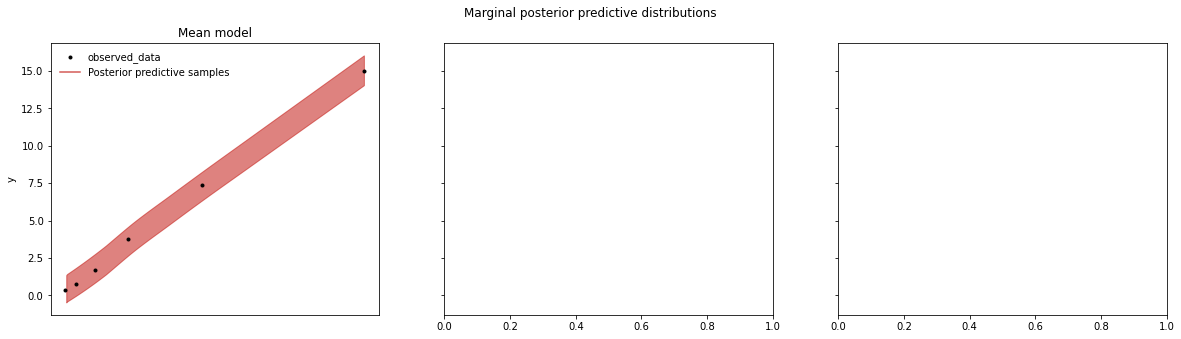

In [24]:
az.style.use(ARVIZ_STYLE)

x = xarray.DataArray(np.linspace(0, 1, 6))
f, axes = plt.subplots(1, 3, figsize=[20, 5], sharey=True)
axes = axes.ravel()
for (posterior_name, posterior), ax in zip(posteriors.items(), axes):
        az.plot_lm(
            y="y",
            x=posteriors["mean_model"].observed_data["x"].values,
            idata=posterior,
            y_hat="yrep",
            axes=ax,
            kind_pp="hdi",
            y_kwargs={"markersize": 6, "color":"black"},
            grid=False
        )
        ax.legend(frameon=False)
        ax.set(title=posterior_name.replace("_", " ").capitalize(), ylabel="")
        ax.set_xticks([], [])
axes[0].set_ylabel("y")

f.suptitle("Marginal posterior predictive distributions")
f.savefig(os.path.join("results", "plots", "posterior_predictive_comparison.png"))

In [23]:
posteriors["mean_model"].observed_data["x"]

<xarray.DataArray 'x' (x_dim_0: 6)>
array([126.   ,  59.8  ,  29.65 ,  16.1  ,   8.3  ,   4.095])
Coordinates:
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5